In [1]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Read the NLS aligned motifs

file_path ='./NLS_sequences_padded.txt'

NLS_sequences = []

with open(file_path, 'r', encoding = 'utf-8') as f:
  for line in f:
    NLS_sequences.append(line.strip())

In [36]:
NLS_sequences

['KRTVETEAVQMLKDIKKE------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KLKEKLK-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'RREFGDSKRVFGERRRN-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
background = {'A':0.0777,
              'C':0.0157,
              'D':0.053,
              'E':0.0656,
              'F':0.0405,
              'G':0.0691,
              'H':0.0227,
              'I':0.0591,
              'K':0.0595,
              'L':0.096,
              'M':0.0238,
              'N':0.0427,
              'P':0.0469,
              'Q':0.0393,
              'R':0.0526,
              'S':0.0694,
              'T':0.055,
              'V':0.0667,
              'W':0.0118,
              'Y':0.0311}
# background = {'M': 0.02211207580407797,
#               'P': 0.07190226876090751,
#               'Y': 0.02350057717452554,
#               'K': 0.07186287865110758,
#               'L': 0.08816710159912904,
#               'E': 0.07915770815211147,
#               'V': 0.05594599178278543,
#               'A': 0.0684939300934968,
#               'C': 0.01752750469125266,
#               'T': 0.04976502705334625,
#               'S': 0.09052722567797492,
#               'G': 0.06453522405860374,
#               'D': 0.052761957907291,
#               'N': 0.035706040363920846,
#               'Q': 0.05032743028771193,
#               'R': 0.05507175017917029,
#               'I': 0.03830797595014963,
#               'F': 0.031072231613845622,
#               'H': 0.02474574231209003,
#               'W': 0.008509357886501775}


In [4]:
class GenericPositionMatrix:
    """Base class for position matrix operations on protein motifs."""
    standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # 20 standard amino acids

    def __init__(self, aligned_sequences):
        self.length = len(aligned_sequences[0])  
        self._validate_sequences(aligned_sequences)  
        self.matrix = self._calculate_position_counts(aligned_sequences)
        self.num_sequences = len(aligned_sequences)
        self.effective_length = self.find_effective_length()  # Calculate effective length after all setups

    def _validate_sequences(self, aligned_sequences):
        if not all(len(seq) == self.length for seq in aligned_sequences):
            raise ValueError("Data has inconsistent lengths.")

    def _calculate_position_counts(self, aligned_sequences):
        aa_counts = defaultdict(lambda: [0] * self.length)
        for seq in aligned_sequences:
            for position, amino_acid in enumerate(seq):
                aa_counts[amino_acid][position] += 1
        return aa_counts

    def find_effective_length(self, threshold=0.9):
        """Dynamically determine the effective NLS length, excluding padding."""
        for position in range(self.length - 1, -1, -1):
            padding_ratio = self.matrix['-'][position] / self.num_sequences
            if padding_ratio < threshold:
                return position + 1  # Return length excluding padding
        return self.length  # Return full length if no padding detected

class PositionWeightMatrix(GenericPositionMatrix):
    """Supports frequency calculations for protein motifs."""

    def normalize(self, background_frequencies=background, pseudocount_factor=1):
        normalized_matrix = {aa: [0.0] * self.effective_length for aa in self.standard_amino_acids}
        total_counts = [0] * self.effective_length

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                pseudocount = background_frequencies[aa] * pseudocount_factor
                count = self.matrix.get(aa, [0] * self.effective_length)[position] + pseudocount
                normalized_matrix[aa][position] = count
                total_counts[position] += count

        for aa, counts in normalized_matrix.items():
            for position, count in enumerate(counts):
                normalized_matrix[aa][position] = count / total_counts[position] if total_counts[position] else 0

        self.matrix = normalized_matrix

    def log_odds(self, background_frequencies=background):
        background_frequencies = background
        # or {aa: 1.0 / len(self.standard_amino_acids) for aa in self.standard_amino_acids}
        log_odds_matrix = {aa: [0] * self.effective_length for aa in self.standard_amino_acids}

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                p = self.matrix[aa][position]
                b = background_frequencies.get(aa, 0)
                score = math.log(p / b, 2) if p > 0 else -math.inf
                log_odds_matrix[aa][position] = score

        return PositionSpecificScoringMatrix(log_odds_matrix, self.effective_length)

class PositionSpecificScoringMatrix:
    """Scores sequences against a Position Specific Scoring Matrix (PSSM)."""

    def __init__(self, matrix, length):
        self.matrix = matrix
        self.length = length
        self.standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    def __str__(self):
        lines = ["   " + " ".join(f"{i:6d}" for i in range(self.length))]
        for amino_acid in self.standard_amino_acids:
            line = f"{amino_acid}: " + " ".join(f"{self.matrix[amino_acid][i]:6.2f}" for i in range(self.length))
            lines.append(line)
        return "\n".join(lines)

    def calculate(self, sequence):
        """Calculate the PSSM score for a given protein sequence."""
        # Initial checks and setup
        sequence = sequence.upper()
        if any(aa not in self.standard_amino_acids for aa in sequence):
            raise ValueError("Sequence contains invalid amino acids for this PSSM.")

        scores = np.empty(len(sequence) - self.length + 1, dtype=np.float32)
        for offset in range(len(scores)):
            score = sum(self.matrix[aa][position] for position, aa in enumerate(sequence[offset:offset + self.length]) if aa in self.matrix)
            scores[offset] = score
        return scores

    def search(self, sequence, threshold=0.0):
        """Find hits in the sequence with PSSM score above a given threshold."""
        sequence = sequence.upper()
        potential_hits = []
        scores = self.calculate(sequence)
        for i, score in enumerate(scores):
            if score >= threshold:
                # yield start + i, score
                potential_hits.append((i, score))

        potential_hits.sort(key=lambda x: x[1], reverse=True)
        return potential_hits

In [27]:
fpm = PositionWeightMatrix(NLS_sequences)
fpm.normalize()  
pssm = fpm.log_odds()
print(pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17
A:  -3.40  -1.20  -1.20  -1.14  -1.16  -1.39  -1.21  -0.31  -0.45  -0.37  -0.98  -0.66  -0.33  -1.97  -0.26  -0.53  -1.36  -0.57
C:  -2.42  -1.83  -1.41  -2.36  -1.59  -0.99  -1.39  -1.66  -1.09  -0.60  -1.17  -1.60   0.26  -0.16  -8.25  -8.15  -7.90  -0.43
D:  -2.00  -3.00  -1.52  -5.08  -0.97  -0.57  -0.88  -0.20  -0.53  -0.77  -1.51  -0.77  -1.13  -0.43  -1.35  -0.48  -2.21   0.51
E:  -2.39  -1.84  -1.08  -0.81  -0.35  -0.38  -0.56  -0.23   0.77   0.74   0.03   0.94  -0.22  -1.21  -1.15  -0.67  -0.95  -0.49
F:  -4.77  -4.19  -1.69  -1.41  -1.37  -2.03  -0.49  -1.03  -0.76  -0.96  -0.22  -2.96  -1.11  -0.26  -1.45  -2.66  -8.44  -0.48
G:  -2.31  -2.03  -0.94  -0.45  -0.79  -0.57  -1.04  -1.07  -0.91  -0.81  -0.31  -0.93  -0.88  -1.80  -0.96   0.14  -1.03  -0.98
H:  -1.63  -0.86  -0.62  -0.64  -0.38  -0.61   0.61   0.30  -1.04  -0.28   0.17  -1.55  -1.08   0

In [6]:
# Plot customized heatmap
def plot_heatmap(pssm, width=10, height=30):
    plt.figure(figsize=(width, height))
    ax = sns.heatmap(pssm, annot=False, cmap='viridis', linewidths=.5,
                    xticklabels=pssm.columns)


    ax.xaxis.tick_top()

    ax.set_xticklabels(pssm.columns, ha="left")
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=True)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Title and labels
    plt.title('PSSM Heatmap', y=1.05)
    plt.xlabel('Amino Acids', labelpad=20)
    plt.ylabel('Position')

    plt.tight_layout()

    plt.show()

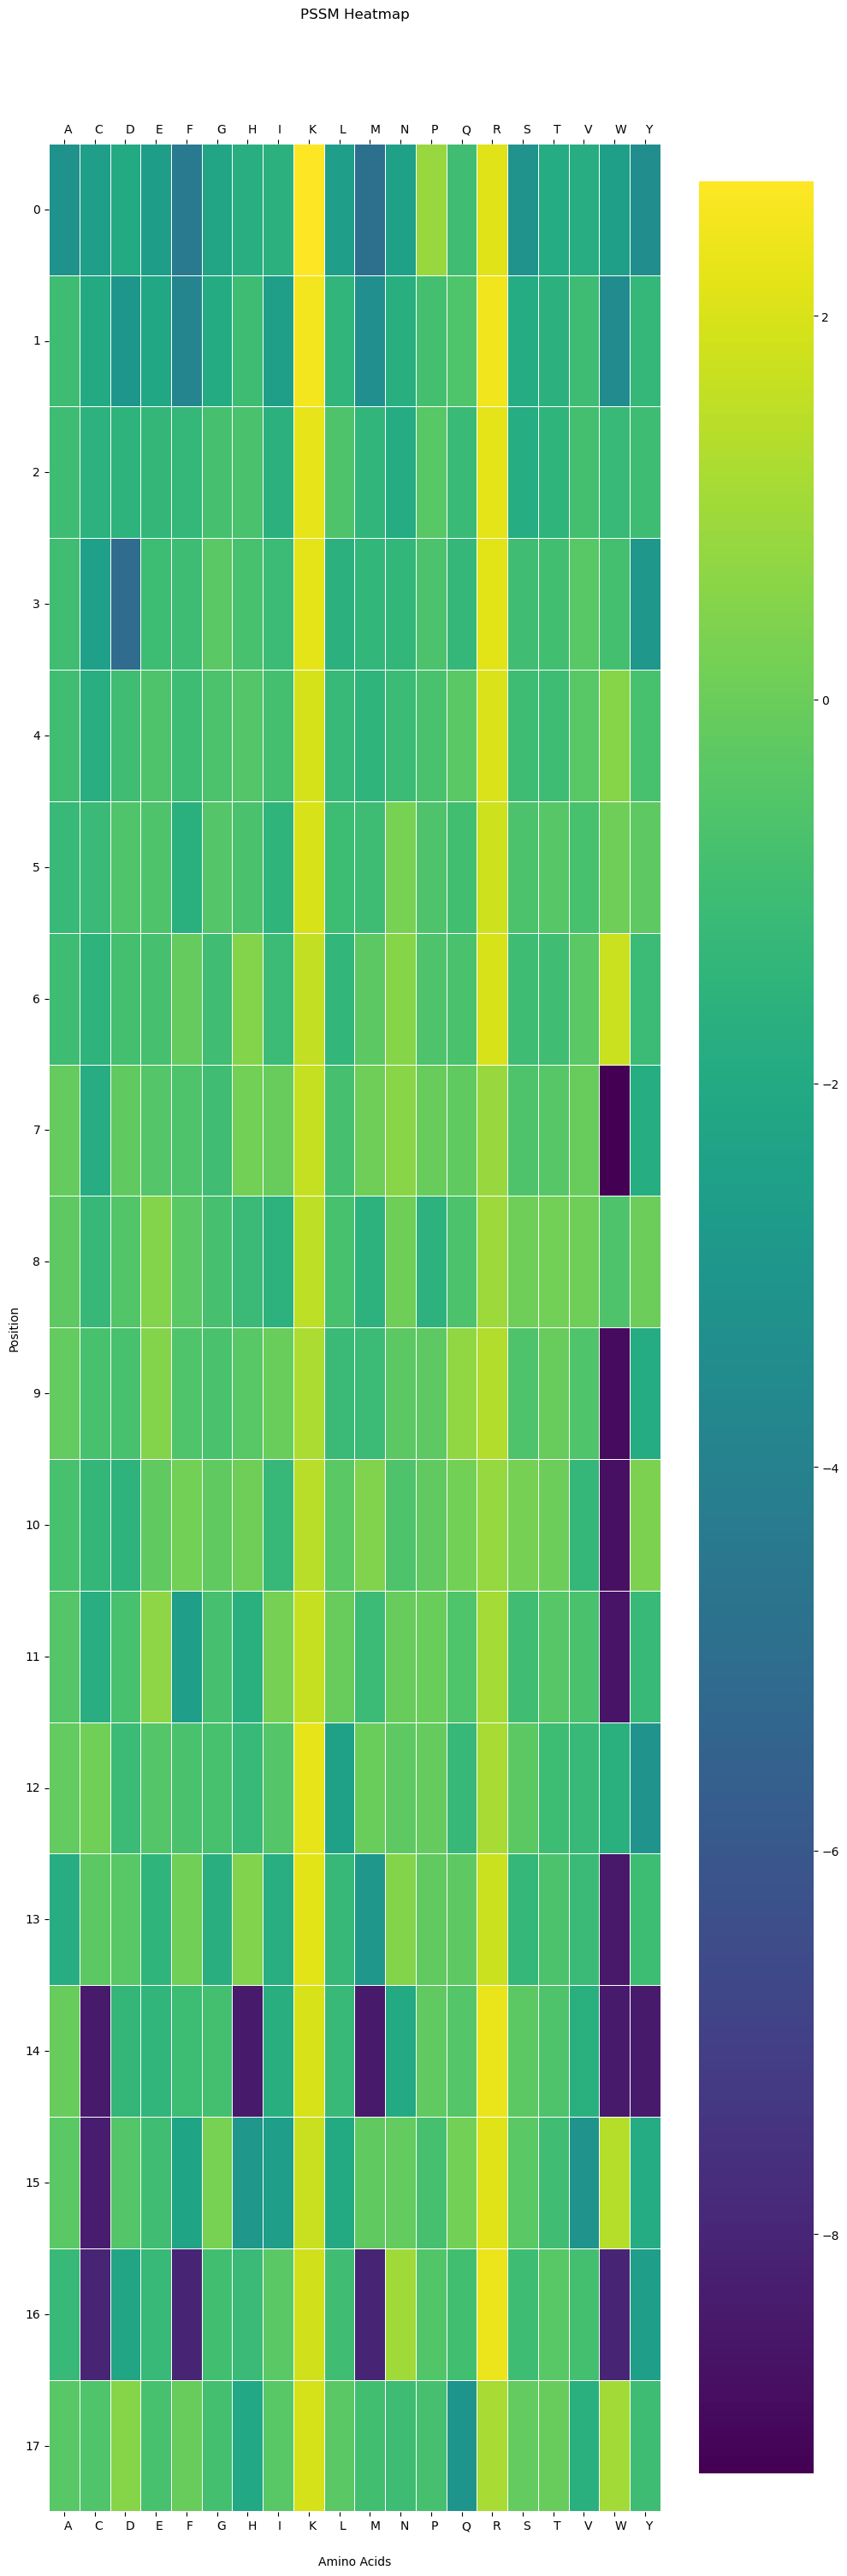

In [7]:
df_pssm = pd.DataFrame(pssm.matrix)

plot_heatmap(df_pssm,10,30)

In [10]:
def compute_scores(pssm, sequence, threshold=2):
    sequence_scores = pssm.calculate(sequence)
    results = pssm.search(sequence,threshold)
    return sequence_scores, results


In [23]:
sequence = """MSNVNLSVSDFWRVMMRVCWLVRQDSRHQRIRLPHLEAVVIGRGPETKITDKKCSRQQVQ
LKAECNKGYVKVKQVGVNPTSIDSVVIGKDQEVKLQPGQVLHMVNELYPYIVEFEEEAKN
PGLETHRKRKRSGNSDSIERDAAQEAEAGTGLEPGSNSGQCSVPLKKGKDAPIKKESLGH
WSQGLKISMQDPKMQVYKDEQVVVIKDKYPKARYHWLVLPWTSISSLKAVAREHLELLKH
MHTVGEKVIVDFAGSSKLRFRLGYHAIPSMSHVHLHVISQDFDSPCLKNKKHWNSFNTEY
FLESQAVIEMVQEAGRVTVRDGMPELLKLPLRCHECQQLLPSIPQLKEHLRKHWTQ"""

sequence = sequence.replace('\n','')


sequence_scores, results = compute_scores(pssm, sequence, threshold = 2)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-29.350634   -30.651249   -29.91836    -26.01646    -26.952875
 -17.469837   -26.038265   -10.368298   -20.30307    -15.580925
 -18.505692   -10.193367   -15.20765     -9.093842    -6.373543
  -5.6773024   -4.4387736   -8.18524     -8.005606    -8.106456
 -16.33215     -7.512095    -6.9350424  -13.624848   -10.659617
  -7.9431586   -3.7583354   -6.051334    -2.8026047   -7.12503
  -5.763052    -4.504327   -11.25941     -5.4036255   -9.868329
  -6.7236094   -4.2996054  -10.098199    -9.915096    -9.930979
  -4.164834     0.29950002  -4.4996653   -9.582071    -1.0069964
  -6.5442705   -3.0670626   -6.285962   -14.084866    -8.669255
  -7.166208    -0.99896455  -2.0185323   -6.798991   -16.210041
   0.09351395 -12.055039    -8.399175    -1.4695307   -8.302151
  -4.284578    -8.651609   -11.631414    -8.569561    -5.5225854
  -4.4151773   -6.0862303  -10.660071   -10.07743     -6.873344
  -7.6625495   -9.081532    -4.250483   -16.822908   -13.773479
 -13.066134    -9.966660

In [28]:
sequence = """MKSNQERSNECLPPKKREIPATSRSSEEKAPTLPSDNHRVEGTAWLPGNPGGRGHGGGRH
GPAGTSVELGLQQGIGLHKALSTGLDYSPPSAPRSVPVATTLPAAYATPQPGTPVSPVQY
AHLPHTFQFIGSSQYSGTYASFIPSQLIPPTANPVTSAVASAAGATTPSQRSQLEAYSTL
LANMGSLSQTPGHKAEQQQQQQQQQQQQHQHQQQQQQQQQQQQQQHLSRAPGLITPGSPP
PAQQNQYVHISSSPQNTGRTASPPAIPVHLHPHQTMIPHTLTLGPPSQVVMQYADSGSHF
VPREATKKAESSRLQQAIQAKEVLNGEMEKSRRYGAPSSADLGLGKAGGKSVPHPYESRH
VVVHPSPSDYSSRDPSGVRASVMVLPNSNTPAADLEVQQATHREASPSTLNDKSGLHLGK
PGHRSYALSPHTVIQTTHSASEPLPVGLPATAFYAGTQPPVIGYLSGQQQAITYAGSLPQ
HLVIPGTQPLLIPVGSTDMEASGAAPAIVTSSPQFAAVPHTFVTTALPKSENFNPEALVT
QAAYPAMVQAQIHLPVVQSVASPAAAPPTLPPYFMKGSIIQLANGELKKVEDLKTEDFIQ
SAEISNDLKIDSSTVERIEDSHSPGVAVIQFAVGEHRAQVSVEVLVEYPFFVFGQGWSSC
CPERTSQLFDLPCSKLSVGDVCISLTLKNLKNGSVKKGQPVDPASVLLKHSKADGLAGSR
HRYAEQENGINQGSAQMLSENGELKFPEKMGLPAAPFLTKIEPSKPAATRKRRWSAPESR
KLEKSEDEPPLTLPKPSLIPQEVKICIEGRSNVGK"""

sequence = sequence.replace('\n','')


sequence_scores, results = compute_scores(pssm, sequence, threshold=1)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [  2.2846026    5.206858    -0.3585944   -3.3505273   -5.971352
  -5.060101    -1.023021    -4.346415    -2.7850955   -1.087777
  -0.46702075   1.4993856    6.7366138    4.3863783    5.807043
   2.8112843   -3.6746645   -5.529843    -3.7641573   -4.8116236
  -8.613803    -3.9243038   -7.4094796  -10.487555    -9.557933
 -12.623054    -9.545533    -8.9066925  -14.115016   -10.539265
 -17.500229   -16.878986   -13.012188   -18.188065   -24.643084
 -14.672631    -6.722021   -17.57086     -7.0726533  -15.251301
 -21.268238   -10.604185   -11.513108   -14.935579   -13.178644
 -16.503181    -7.948376    -9.361938    -6.5306125   -9.095935
  -9.128213   -11.339068    -9.127344   -12.2748     -13.647442
 -13.79395    -13.329571    -8.484568    -8.07351    -14.375552
 -16.759527   -11.9192295  -17.06468    -20.104954   -13.845347
 -13.022734   -15.721232   -13.235893   -14.609954   -18.676361
 -14.639394   -11.406849   -19.82434    -11.116375   -14.036474
 -11.482462    -6.54178 

In [14]:
sequence = """MSNVNLSVSDFWRVMMRVCWLVRQDSRHQRIRLPHLEAVVIGRGPETKITDKKCSRQQVQ
LKAECNKGYVKVKQVGVNPTSIDSVVIGKDQEVKLQPGQVLHMVNELYPYIVEFEEEAKN
PGLETHRKRKRSGNSDSIERDAAQEAEAGTGLEPGSNSGQCSVPLKKGKDAPIKKESLGH
WSQGLKISMQDPKMQVYKDEQVVVIKDKYPKARYHWLVLPWTSISSLKAVAREHLELLKH
MHTVGEKVIVDFAGSSKLRFRLGYHAIPSMSHVHLHVISQDFDSPCLKNKKHWNSFNTEY
FLESQAVIEMVQEAGRVTVRDGMPELLKLPLRCHECQQLLPSIPQLKEHLRKHWTQ"""
sequence = sequence.replace('\n','')

sequence_scores, results = compute_scores(pssm, sequence, threshold=1)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-29.350634   -30.651249   -29.91836    -26.01646    -26.952875
 -17.469837   -26.038265   -10.368298   -20.30307    -15.580925
 -18.505692   -10.193367   -15.20765     -9.093842    -6.373543
  -5.6773024   -4.4387736   -8.18524     -8.005606    -8.106456
 -16.33215     -7.512095    -6.9350424  -13.624848   -10.659617
  -7.9431586   -3.7583354   -6.051334    -2.8026047   -7.12503
  -5.763052    -4.504327   -11.25941     -5.4036255   -9.868329
  -6.7236094   -4.2996054  -10.098199    -9.915096    -9.930979
  -4.164834     0.29950002  -4.4996653   -9.582071    -1.0069964
  -6.5442705   -3.0670626   -6.285962   -14.084866    -8.669255
  -7.166208    -0.99896455  -2.0185323   -6.798991   -16.210041
   0.09351395 -12.055039    -8.399175    -1.4695307   -8.302151
  -4.284578    -8.651609   -11.631414    -8.569561    -5.5225854
  -4.4151773   -6.0862303  -10.660071   -10.07743     -6.873344
  -7.6625495   -9.081532    -4.250483   -16.822908   -13.773479
 -13.066134    -9.966660

In [15]:
sequence = """MAPRGRRRPRPHRSEGARRSKNTLERTHSMKDKAGQKCKPIDVFDFPDNSDVSSIGRLGE
NEKDEETYETFDPPLHSTAIYADEEEFSKHCGLSLSSTPPGKEAKRSSDTSGNEASEIES
VKISAKKPGRKLRPISDDSESIEESDTRRKVKSAEKISTQRHEVIRTTASSELSEKPAES
VTSKKTGPLSAQPSVEKENLAIESQSKTQKKGKISHDKRKKSRSKAIGSDTSDIVHIWCP
EGMKTSDIKELNIVLPEFEKTHLEHQQRIESKVCKAAIATFYVNVKEQFIKMLKESQMLT
NLKRKNAKMISDIEKKRQRMIEVQDELLRLEPQLKQLQTKYDELKERKSSLRNAAYFLSN
LKQLYQDYSDVQAQEPNVKETYDSSSLPALLFKARTLLGAESHLRNINHQLEKLLDQG"""
sequence = sequence.replace('\n','')

sequence_scores, results = compute_scores(pssm, sequence, threshold=1)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-3.71207237e+00  5.78047323e+00  8.57565880e+00  1.16800165e+01
  8.73809624e+00  1.38804731e+01  7.18010950e+00  5.57647169e-01
  2.68415761e+00  3.27825093e+00 -2.63914490e+00 -4.99430466e+00
 -2.42591119e+00 -1.66954651e+01  1.16818678e+00 -7.25728416e+00
  7.17380524e-01  1.89176488e+00 -2.66552591e+00 -1.32449567e+00
 -1.10766768e+00 -1.13682537e+01 -9.89440441e+00 -1.09396267e+01
  7.13471174e-01 -3.58022213e+00 -4.84087896e+00 -1.69437904e+01
 -1.47459307e+01 -1.50128822e+01 -6.29767799e+00 -9.30376625e+00
 -5.12381124e+00 -9.23842621e+00 -1.43565722e+01 -4.44353628e+00
 -9.41305161e+00 -1.00846825e+01 -1.65275688e+01 -1.19013443e+01
 -1.38327560e+01 -1.69015141e+01 -1.49791889e+01 -1.37064991e+01
 -1.83471527e+01 -1.48154688e+01 -1.27826004e+01 -1.60953407e+01
 -1.20011215e+01 -1.42612963e+01 -8.23661137e+00 -1.47029753e+01
 -1.20855150e+01 -1.64543972e+01 -1.51066103e+01 -1.15331869e+01
 -5.80737400e+00 -9.77408504e+00 -1.48814507e+01 -1.32452745e+01
 -1.715102

In [29]:
sequence = """MDGVSSEANEENDNIERPVRRRHSSILKPPRSPLQDLRGGNERVQESNALRNKKNSRRVS
FADTIKVFQTESHMKIVRKSEMEGCSAMVPSQLQLLPPGFKRFSCLSLPETETGENLLLI
QNKKLEDNYCEITGMNTLLSAPIHTQMQQKEFSIIEHTRERKHANDQTVIFSDENQMDLT
SSHTVMITKGLLDNPISEKSTKIDTTSFLANLKLHTEDSRMKKEVNFSVDQNTSSENKID
FNDFIKRLKTGKCSAFPDVPDKENFEIPIYSKEPNSASSTHQMHVSLKEDENNSNITRLF
REKDDGMNFTQCHTANIQTLIPTSSETNSRESKGNDITIYGNDFMDLTFNHTLQILPATG
NFSEIENQTQNAMDVTTGYGTKASGNKTVFKSKQNTAFQDLSINSADKIHITRSHIMGAE
THIVSQTCNQDARILAMTPESIYSNPSIQGCKTVFYSSCNDAMEMTKCLSNMREEKNLLK
HDSNYAKMYCNPDAMSSLTEKTIYSGEENMDITKSHTVAIDNQIFKQDQSNVQIAAAPTP
EKEMMLQNLMTTSEDGKMNVNCNSVPHVSKERIQQSLSNPLSISLTDRKTELLSGENMDL
TESHTSNLGSQVPLAAYNLAPESTSESHSQSKSSSDECEEITKSRNEPFQRSDIIAKNSL
TDTWNKDKDWVLKILPYLDKDSPQSADCNQEIATSHNIVYCGGVLDKQITNRNTVSWEQS
LFSTTKPLFSSGQFSMKNHDTAISSHTVKSVLGQNSKLAEPLRKSLSNPTPDYCHDKMII
CSEEEQNMDLTKSHTVVIGFGPSELQELGKTNLEHTTGQLTTMNRQIAVKVEKCGKSPIE
KSGVLKSNCIMDVLEDESVQKPKFPKEKQNVKIWGRKSVGGPKIDKTIVFSEDDKNDMDI
TKSYTIEINHRPLLEKRDCHLVPLAGTSETILYTCRQDDMEITRSHTTALECKTVSPDEI
TTRPMDKTVVFVDNHVELEMTESHTVFIDYQEKERTDRPNFELSQRKSLGTPTVICTPTE
ESVFFPGNGESDRLVANDSQLTPLEEWSNNRGPVEVADNMELSKSATCKNIKDVQSPGFL
NEPLSSKSQRRKSLKLKNDKTIVFSENHKNDMDITQSCMVEIDNESALEDKEDFHLAGAS
KTILYSCGQDDMEITRSHTTALECKTLLPNEIAIRPMDKTVLFTDNYSDLEVTDSHTVFI
DCQATEKILEENPKFGIGKGKNLGVSFPKDNSCVQEIAEKQALAVGNKIVLHTEQKQQLF
AATNRTTNEIIKFHSAAMDEKVIGKVVDQACTLEKAQVESCQLNNRDRRNVDFTSSHATA
VCGSSDNYSCLPNVISCTDNLEGSAMLLCDKDEEKANYCPVQNDLAYANDFASEYYLESE
GQPLSAPCPLLEKEEVIQTSTKGQLDCVITLHKDQDLIKDPRNLLANQTLVYSQDLGEMT
KLNSKRVSFKLPKDQMKVYVDDIYVIPQPHFSTDQPPLPKKGQSSINKEEVILSKAGNKS
LNIIENSSAPICENKPKILNSEEWFAAACKKELKENIQTTNYNTALDFHSNSDVTKQVIQ
THVNAGEAPDPVITSNVPCFHSIKPNLNNLNGKTGEFLAFQTVHLPPLPEQLLELGNKAH
NDMHIVQATEIHNINIISSNAKDSRDEENKKSHNGAETTSLPPKTVFKDKVRRCSLGIFL
PRLPNKRNCSVTGIDDLEQIPADTTDINHLETQPVSSKDSGIGSVAGKLNLSPSQYINEE
NLPVYPDEINSSDSINIETEEKALIETYQKEISPYENKMGKTCNSQKRTWVQEEEDIHKE
KKIRKNEIKFSDTTQDREIFDHHTEEDIDKSANSVLIKNLSRTPSSCSSSLDSIKADGTS
LDFSTYRSSQMESQFLRDTICEESLREKLQDGRITIREFFILLQVHILIQKPRQSNLPGN
FTVNTPPTPEDLMLSQYVYRPKIQIYREDCEARRQKIEELKLSASNQDKLLVDINKNLWE
KMRHCSDKELKAFGIYLNKIKSCFTKMTKVFTHQGKVALYGKLVQSAQNEREKLQIKIDE
MDKILKKIDNCLTEMETETKNLEDEEKNNPVEEWDSEMRAAEKELEQLKTEEEELQRNLL
ELEVQKEQTLAQIDFMQKQRNRTEELLDQLSLSEWDVVEWSDDQAVFTFVYDTIQLTITF
EESVVGFPFLDKRYRKIVDVNFQSLLDEDQAPPSSLLVHKLIFQYVEEKESWKKTCTTQH
QLPKMLEEFSLVVHHCRLLGEEIEYLKRWGPNYNLMNIDINNNELRLLFSSSAAFAKFEI
TLFLSAYYPSVPLPSTIQNHVGNTSQDDIATILSKVPLENNYLKNVVKQIYQDLFQDCHF
YH"""
sequence = sequence.replace('\n','')

sequence_scores, results = compute_scores(pssm, sequence, threshold=2)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-12.798209 -11.500453  -9.037681 ... -15.34039  -29.760332 -25.500097]

Match begins at 17 with score 11.530954360961914 and amino acid R
Match begins at 16 with score 8.764081954956055 and amino acid E
Match begins at 1801 with score 6.621522903442383 and amino acid K
Match begins at 1083 with score 6.076837539672852 and amino acid P
Match begins at 1085 with score 5.963537693023682 and amino acid S
Match begins at 1785 with score 5.822895526885986 and amino acid S
Match begins at 1940 with score 5.244018077850342 and amino acid R
Match begins at 1799 with score 5.2260541915893555 and amino acid K
Match begins at 246 with score 5.184289932250977 and amino acid K
Match begins at 1953 with score 4.775723457336426 and amino acid R
Match begins at 1786 with score 4.584037780761719 and amino acid Q
Match begins at 1441 with score 4.502444267272949 and amino acid K
Match begins at 42 with score 4.46986198425293 and amino acid E
Match begins at 992 with score 4.44642591476440